# Setting up

In [1]:
from distribution_classes import Simple_Gaussian, Banana_Gaussian
from generate_means import regular_expectancy, new_expectancy, box_comp, MH
from model_building import build_model
from optimisation import estimate_params

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#dev = torch.device(
#    "cuda") if torch.cuda.is_available() else torch.device("cpu")


In [5]:
dev = torch.device("cpu")

In [6]:
dev

device(type='cpu')

In [7]:
data_dimensions = 2 # how many dimensions are there in our variable

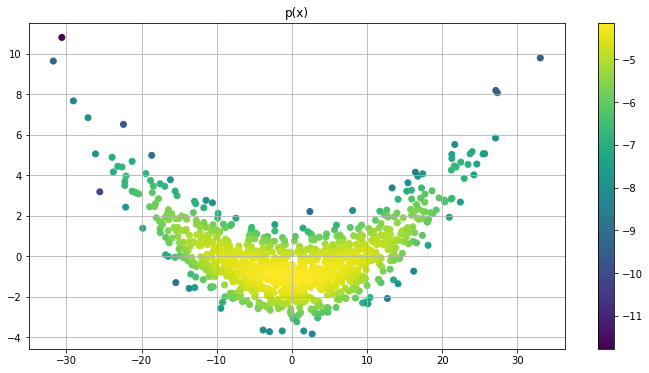

In [8]:
p = 100
b = 0.01
p_dist = Banana_Gaussian(p, b, dev = dev)
samps = p_dist.sampler(1000)
log_p = p_dist.log_pdf(samps).cpu()
samps = samps.cpu()
plt.figure(figsize=(12, 6))
plt.scatter(samps[:, 0], samps[:, 1], c = log_p)
cbar= plt.colorbar()
plt.title('p(x)')
plt.grid()
plt.show()

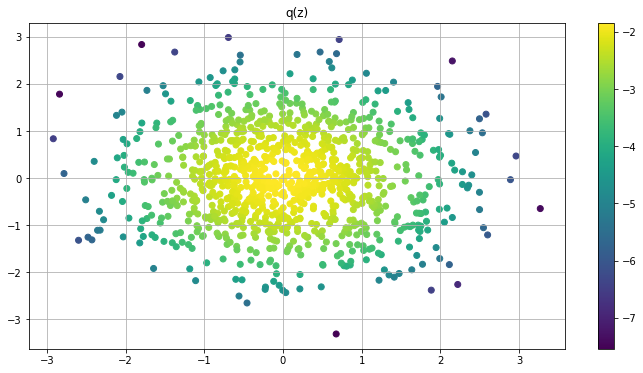

In [9]:
q_dist = Simple_Gaussian(dimensions = data_dimensions, dev = dev)
samps = q_dist.sampler(1000)
log_p = q_dist.log_pdf(samps).cpu()
samps = samps.cpu()
plt.figure(figsize=(12, 6))
plt.scatter(samps[:, 0], samps[:, 1], c = log_p)
cbar= plt.colorbar()
plt.title('q(z)')
plt.grid()
plt.show()

# Comparing to results from paper

In [101]:
def func(x):
    #specifying h(x)
    return x[:, 1]

In [70]:
model = build_model(data_dimensions, 9, 3, 'maf')

In [71]:
model = model.to(dev)
p_dist = p_dist.to(dev)
q_dist = q_dist.to(dev)

Cur iter: 4
Curr_loss: tensor(1.7680, grad_fn=<AddBackward0>)
Min_loss: 1.7680219411849976
Current epochs: 20000
Current tolerance: tensor(1.4305e-06, grad_fn=<AbsBackward>)


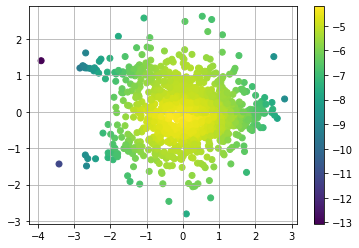

In [72]:
estimate_params(p_dist, q_dist, func, model, sample_size = 10**3, lear_rt = 1e-4, epoch_amnt = 20*10**3, lr_downing_num =5)

In [73]:
model.eval()
print("~")

~


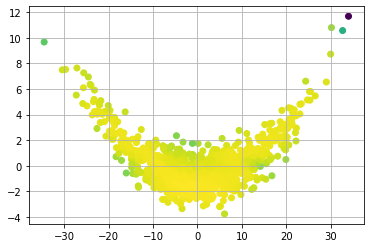

In [74]:
#f(X)

testin = p_dist.sampler(10**3)
trans, log_det = model.forward(testin)
testin = testin.cpu()
color = (q_dist.log_pdf(trans) + log_det.squeeze()).detach().cpu()
plt.scatter(testin[:, 0], testin[:, 1],  c = color)
plt.grid()

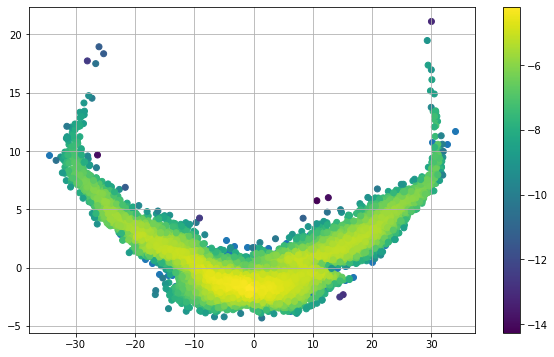

In [75]:
# g(Z), Z~q(z) compared to X~p(x)

new_data = q_dist.sampler(10**4)
trans, log_det = model.forward(new_data, mode='inverse')
plotting = trans.detach().cpu()
color = (q_dist.log_pdf(new_data) - log_det.reshape(1, -1)).detach().cpu()
plt.figure(figsize=(10, 6))
plt.scatter(testin[:, 0], testin[:, 1])
plt.scatter(plotting[:, 0], plotting[:, 1], c = color )

cbar= plt.colorbar()
plt.grid()

  0%|          | 0/10 [00:00<?, ?it/s]

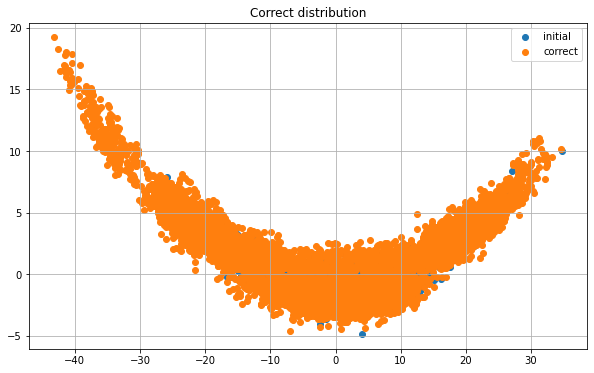

In [103]:
smps = MH(func, p_dist.log_pdf, 10**4, 2)

plt.figure(figsize=(10, 6))
plt.title('Correct distribution')
testin = p_dist.sampler(10**3)
testin = testin.cpu()
plt.scatter(testin[:, 0], testin[:, 1], label = 'initial')
plt.scatter(smps[:, 0], smps[:, 1], label = 'correct')

plt.grid()
plt.legend()

In [77]:
reg = regular_expectancy(func, p_dist, 100, 10**3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
newe = new_expectancy(func, p_dist, q_dist, 100, 10**3, model)

  0%|          | 0/100 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90


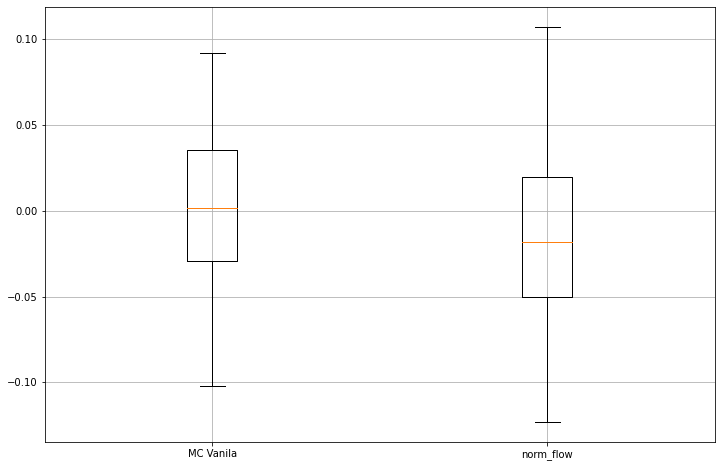

In [79]:
box_comp(reg, newe) 

In [80]:
van_var = np.var(reg)
flow_var = np.var(newe)
print("Baseline variance:", van_var)
print("Variance of our approach:", flow_var)
print("Reduction rate:", van_var/flow_var)

Baseline variance: 0.00241145849839736
Variance of our approach: 0.0025549558412532565
Reduction rate: 0.9438356857136488


# Test on another function with smaller intersection region

In [41]:
def func(x):
    #specifying h(x)
    return (x[:, 1] > 4).type(torch.float)

In [42]:
model = build_model(data_dimensions, 9, 3, 'realnvp', dev = dev)

In [43]:
model = model.to(dev)

Cur iter: 2
Curr_loss: tensor(0.0014, grad_fn=<AddBackward0>)
Min_loss: 0.0014367797411978245
Current epochs: 1000
Current tolerance: tensor(4.8662e-07, grad_fn=<AbsBackward>)


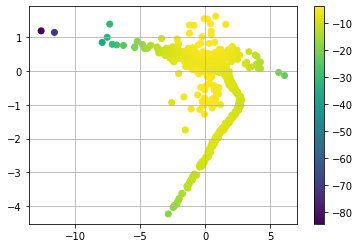

nan loss
nan loss
nan loss


In [44]:
estimate_params(p_dist, q_dist, func, model, sample_size = 10**3, lear_rt = 1e-4, epoch_amnt = 20*10**3, lr_downing_num =5, dev = dev)

In [45]:
model.eval()
print("~")

~


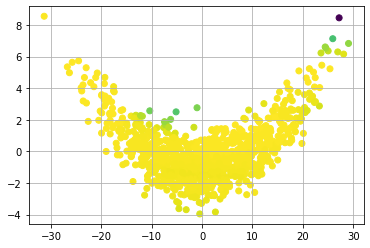

In [46]:
#f(X)

testin = p_dist.sampler(10**3)
trans, log_det = model.forward(testin)
testin = testin.cpu()
color = (q_dist.log_pdf(trans) + log_det.squeeze()).detach().cpu()
plt.scatter(testin[:, 0], testin[:, 1],  c = color)
plt.grid()

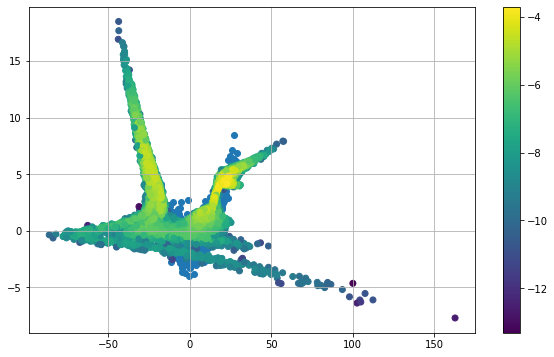

In [47]:
# g(Z), Z~q(z) compared to X~p(x)

new_data = q_dist.sampler(10**4)
trans, log_det = model.forward(new_data, mode='inverse')
plotting = trans.detach().cpu()
color = (q_dist.log_pdf(new_data) - log_det.reshape(1, -1)).detach().cpu()
plt.figure(figsize=(10, 6))
plt.scatter(testin[:, 0], testin[:, 1])
plt.scatter(plotting[:, 0], plotting[:, 1], c = color )

cbar= plt.colorbar()
plt.grid()

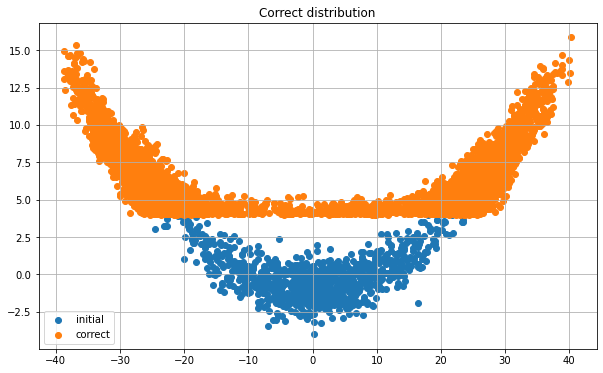

In [48]:
smps = MH(func, p_dist.log_pdf, 10**4, 2)

plt.figure(figsize=(10, 6))
plt.title('Correct distribution')
testin = p_dist.sampler(10**3)
testin = testin.cpu()
plt.scatter(testin[:, 0], testin[:, 1], label = 'initial')
plt.scatter(smps[:, 0], smps[:, 1], label = 'correct')

plt.grid()
plt.legend()

In [49]:
reg = regular_expectancy(func, p_dist, 100, 10**3)

In [50]:
newe = new_expectancy(func, p_dist, q_dist, 100, 10**3, model)

0
10
20
30
40
50
60
70
80
90



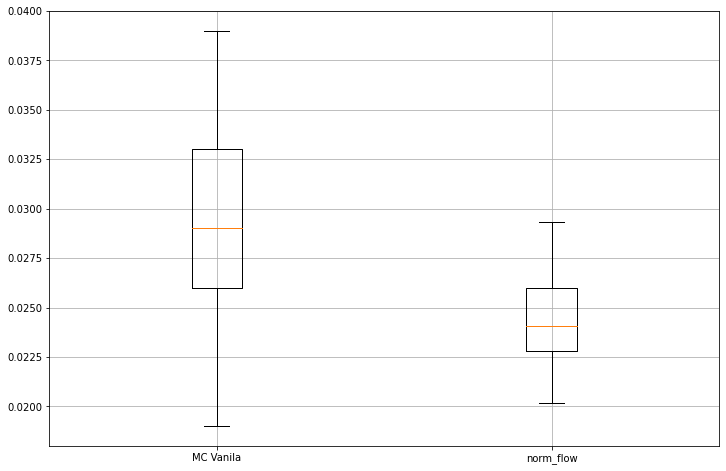

In [51]:
box_comp(reg, newe)

In [52]:
van_var = np.var(reg)
flow_var = np.var(newe)
print("Baseline variance:", van_var)
print("Variance of our approach:", flow_var)
print("Reduction rate:", van_var/flow_var)

Baseline variance: 2.4214401329434728e-05
Variance of our approach: 4.314336861394679e-05
Reduction rate: 0.5612543041344025


# Importance sampling-like setting, Test 2

In [10]:
def func(x):
    #specifying h(x)
    x1 = x[:, 0]
    x2 = x[:, 1] - b*x1**2 + p*b
    return (x1**2/p + x2**2) * (x1**2/p + x2**2 > 3).type(torch.float)


In [45]:
model = build_model(data_dimensions, 5, 5, 'maf', dev = dev)

In [46]:
model = model.to(dev)

Cur iter: 3
Curr_loss: tensor(3487.0229, grad_fn=<AddBackward0>)
Min_loss: 3487.02294921875
Current epochs: 15000
Current tolerance: tensor(0.0022, grad_fn=<AbsBackward>)


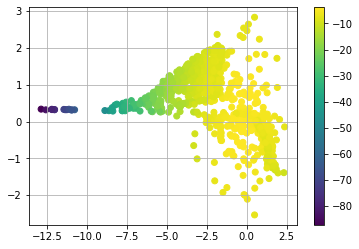

nan loss
nan loss


In [47]:
estimate_params(p_dist, q_dist, func, model, sample_size = 10**3, lear_rt = 1e-4, epoch_amnt = 20*10**3, lr_downing_num =5, dev = dev)

In [48]:
model.eval();

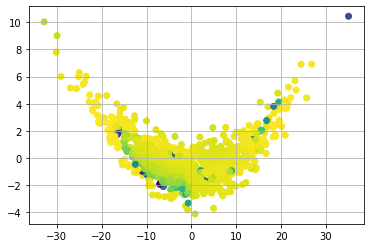

In [49]:
#f(X)

testin = p_dist.sampler(10**3)
trans, log_det = model.forward(testin)
testin = testin.cpu()
color = (q_dist.log_pdf(trans) + log_det.squeeze()).detach().cpu()
plt.scatter(testin[:, 0], testin[:, 1],  c = color)
plt.grid()

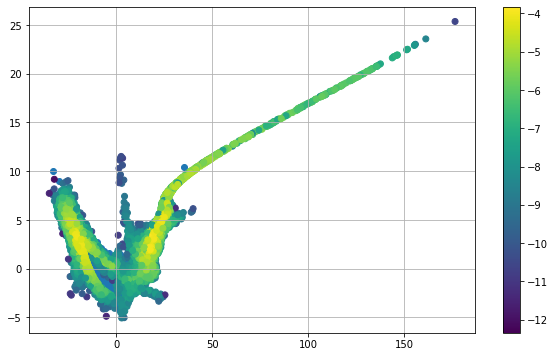

In [50]:
# g(Z), Z~q(z) compared to X~p(x)

new_data = q_dist.sampler(10**4)
trans, log_det = model.forward(new_data, mode='inverse')
plotting = trans.detach().cpu()
color = (q_dist.log_pdf(new_data) - log_det.reshape(1, -1)).detach().cpu()
plt.figure(figsize=(10, 6))
plt.scatter(testin[:, 0], testin[:, 1])
plt.scatter(plotting[:, 0], plotting[:, 1], c = color )

cbar= plt.colorbar()
plt.grid()

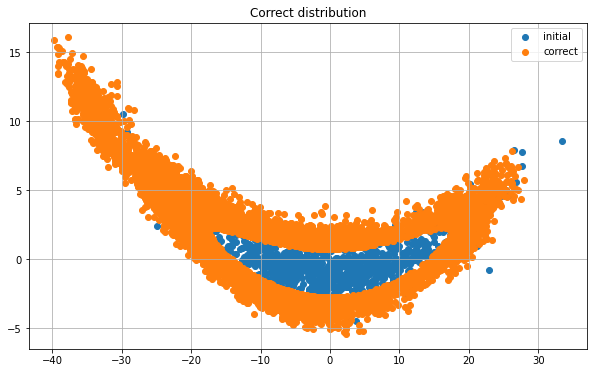

In [11]:
smps = MH(func, p_dist.log_pdf, 10**4, 2)

plt.figure(figsize=(10, 6))
plt.title('Correct distribution')
testin = p_dist.sampler(10**3)
testin = testin.cpu()
plt.scatter(testin[:, 0], testin[:, 1], label = 'initial')
plt.scatter(smps[:, 0], smps[:, 1], label = 'correct')

plt.grid()
plt.legend()
plt.show()


In [52]:
smps.shape

torch.Size([10000, 2])

In [53]:
reg = regular_expectancy(func, p_dist, 100, 10**3)

In [54]:
newe = new_expectancy(func, p_dist, q_dist, 100, 10**3, model)

0
10
20
30
40
50
60
70
80
90



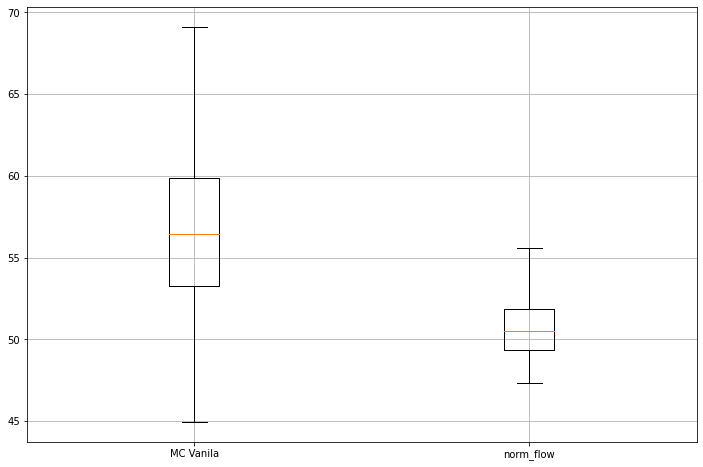

In [55]:
box_comp(reg, newe)

In [56]:
van_var = np.var(reg)
flow_var = np.var(newe)
print("Baseline variance:", van_var)
print("Variance of our approach:", flow_var)
print("Reduction rate:", van_var/flow_var)

Baseline variance: 22.780721586837895
Variance of our approach: 40.88371065624902
Reduction rate: 0.5572077783833912
